Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [x] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [X] Begin with baselines for classification.
- [x] Use scikit-learn for logistic regression.
- [x] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [x] Get your model's test accuracy. (One time, at the end.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
import numpy as np
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

## select features

In [7]:
df.dtypes

Burrito            object
Date               object
Yelp              float64
Google            float64
Chips              object
Cost              float64
Hunger            float64
Mass (g)          float64
Density (g/mL)    float64
Length            float64
Circum            float64
Volume            float64
Tortilla          float64
Temp              float64
Meat              float64
Fillings          float64
Meat:filling      float64
Uniformity        float64
Salsa             float64
Synergy           float64
Wrap              float64
Unreliable         object
NonSD              object
Beef               object
Pico               object
Guac               object
Cheese             object
Fries              object
Sour cream         object
Pork               object
Chicken            object
Shrimp             object
Fish               object
Rice               object
Beans              object
Lettuce            object
Tomato             object
Bell peper         object
Carrots     

# i think that covers the removal of features time to see if i need to impute or drop any

In [8]:
def print_missing():
  for col in df.columns:
    ratio=df[col].isnull().sum()*100/len(df[col])
    if ratio>20:
      print(f"Column {col} is missing {round(ratio,4)}% of it's values and is a good canidate for imputing or dropping")
    else:
      print(f"Column {col} has a missing value ratio of {round(ratio,4)}")
  return None
print_missing()

Column Burrito has a missing value ratio of 0.0
Column Date has a missing value ratio of 0.0
Column Yelp is missing 79.3349% of it's values and is a good canidate for imputing or dropping
Column Google is missing 79.3349% of it's values and is a good canidate for imputing or dropping
Column Chips is missing 93.8242% of it's values and is a good canidate for imputing or dropping
Column Cost has a missing value ratio of 1.6627
Column Hunger has a missing value ratio of 0.7126
Column Mass (g) is missing 94.7743% of it's values and is a good canidate for imputing or dropping
Column Density (g/mL) is missing 94.7743% of it's values and is a good canidate for imputing or dropping
Column Length is missing 32.7791% of it's values and is a good canidate for imputing or dropping
Column Circum is missing 33.2542% of it's values and is a good canidate for imputing or dropping
Column Volume is missing 33.2542% of it's values and is a good canidate for imputing or dropping
Column Tortilla has a miss

### Ouch definattly have some work to do here

In [0]:
# dropping columns that are not particularly usefull
# queso has no values in it, just adds NaNs to the dataframe
# mass and density and chips do not add enough explained varriance to the model and have too many NaN values to impute without adding a unnatural bias
df=df.drop(['Mass (g)','Density (g/mL)','Queso','Chips'],axis=1)
# subset the rest of the values that hav 'x','X',or nan for processing
df_ingredients=df.drop(['Tortilla','Cost', 'Hunger','Length' ,'Circum', 'Volume', 'Temp', 'Meat', 'Fillings', 'Meat:filling' ,'Uniformity', 'Date','Wrap' ,'Burrito', 'Salsa', 'Great'],axis=1)

In [0]:
# make a function that makes string into true and bools into false for my ingredent list
def cast_ings(x) -> bool:
  if isinstance(x,str):
    return True
  else:
    return False
# convert all of the ingrediencts to true or false
for col in df_ingredients:
  df_ingredients[col]=df_ingredients[col].apply(cast_ings)  
# change the dataframe to reflect the true/false processesing
df[df_ingredients.columns.to_list()]=df_ingredients[df_ingredients.columns.to_list()]


In [11]:
print_missing()

Column Burrito has a missing value ratio of 0.0
Column Date has a missing value ratio of 0.0
Column Yelp has a missing value ratio of 0.0
Column Google has a missing value ratio of 0.0
Column Cost has a missing value ratio of 1.6627
Column Hunger has a missing value ratio of 0.7126
Column Length is missing 32.7791% of it's values and is a good canidate for imputing or dropping
Column Circum is missing 33.2542% of it's values and is a good canidate for imputing or dropping
Column Volume is missing 33.2542% of it's values and is a good canidate for imputing or dropping
Column Tortilla has a missing value ratio of 0.0
Column Temp has a missing value ratio of 4.7506
Column Meat has a missing value ratio of 3.3254
Column Fillings has a missing value ratio of 0.7126
Column Meat:filling has a missing value ratio of 2.1378
Column Uniformity has a missing value ratio of 0.4751
Column Salsa has a missing value ratio of 5.9382
Column Synergy has a missing value ratio of 0.0
Column Wrap has a miss

### thats 'more better' lets go ahead and start the pipeline

## split diffrent dataframes up by date, set labels

In [0]:
# convert existing Date column into DateTime objects
df['Date']=pd.to_datetime(df['Date'],infer_datetime_format=True)
# make seperate dataframes based on year
train=df[df['Date'].dt.year<=2016]
validate=df[df['Date'].dt.year==2017]
test=df[df['Date'].dt.year==2018]

# seperate out my labels
target='Great'
y_train=train[target]
y_validate=validate[target]
y_test=test[target]

In [13]:
# take a look at what we have
train.head()

,Burrito,Date,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,False,False,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,False,4.0,False,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,California,2016-01-24,False,False,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,False,5.0,False,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Carnitas,2016-01-24,False,False,4.85,1.5,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,False,5.0,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Asada,2016-01-24,False,False,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,False,5.0,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,California,2016-01-27,False,False,6.59,4.0,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,False,4.0,False,False,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


## Baseline Model: LinearReggression

In [0]:
# lets make feature sets
features=['Tortilla'	,'Temp'	,'Meat'	,'Fillings'	,'Meat:filling'	,'Uniformity'	,'Salsa','Wrap']
target='Great'
X_train=train[features]
X_validate=validate[features]

In [0]:
# impute NaN values
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='mean')
X_train_imputed=imputer.fit_transform(X_train)
X_validate_imputed=imputer.transform(X_validate)

Model Training R^2 score: 0.5037115216850532
Model Training MAE: 0.2989525532051837

Model Validation R^2 score: 0.44415344842224447
Model Validation MAE: 0.3409326713307951


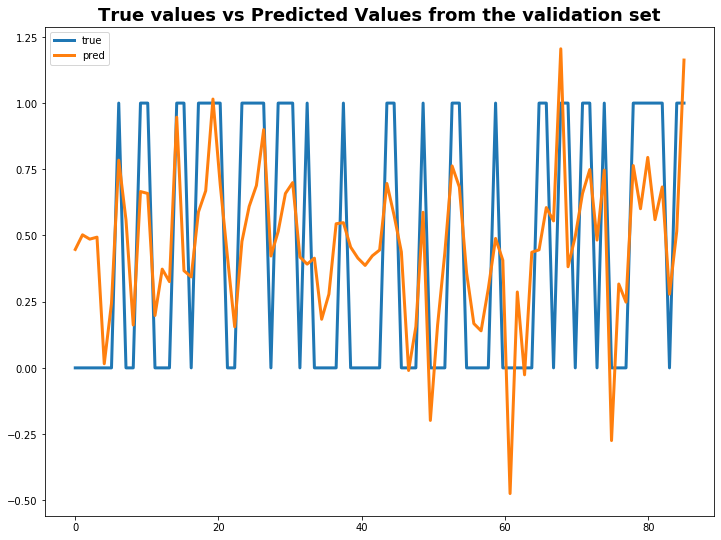

In [16]:
# time to establish a baseline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import math
plt.rcParams['figure.figsize']=[12,9]

model=LinearRegression(n_jobs=-1)
# fit the model with the imputed values predict on 
# both sets and then print some scores
model.fit(X_train_imputed,y_train)

print(f"Model Training R^2 score: {model.score(X_train_imputed,y_train)}")
y_pred=model.predict(X_train_imputed)
print(f"Model Training MAE: {mean_absolute_error(y_pred,y_train)}\n")

print(f"Model Validation R^2 score: {model.score(X_validate_imputed,y_validate)}")
y_pred=model.predict(X_validate_imputed)
print(f"Model Validation MAE: {mean_absolute_error(y_pred,y_validate)}")

plt.plot(np.linspace(0,len(y_validate),num=85),y_validate,label='true',lw=3)
plt.plot(np.linspace(0,len(y_validate),num=85),y_pred,label='pred',lw=3)
plt.title("True values vs Predicted Values from the validation set",fontweight='bold',fontsize=18)
plt.legend()
plt.show()

### Well that is pretty Trash IMO but at the same time regression on a  clasification problem will always be Trash

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# make feature sets
X_train=train.drop(['Burrito','Great','Date'],axis=1)
X_validate=validate.drop(['Burrito','Great','Date'],axis=1)
X_train_imputed=imputer.fit_transform(X_train)
X_validate_imputed=imputer.transform(X_validate)

In [18]:
# init
model=LogisticRegression(solver='lbfgs',max_iter=1000,random_state=42)
# fit
model.fit(X_train_imputed,y_train)
# predict and score training and validation accuracy
y_pred=model.predict(X_train_imputed)
acc=accuracy_score(y_pred=y_pred,y_true=y_train)
print(f"TRAINING ACCURACY:{acc}")
y_pred=model.predict(X_validate_imputed)
acc=accuracy_score(y_pred=y_pred,y_true=y_validate)
print(f"VALIDATION ACCURACY:{acc}")

TRAINING ACCURACY:0.8993288590604027
VALIDATION ACCURACY:0.8235294117647058


In [19]:
# test model
X_test=test.drop(['Burrito','Great','Date'],axis=1)
X_test_imputed=imputer.transform(X_test)
y_pred=model.predict(X_test_imputed)
acc=accuracy_score(y_true=y_test,y_pred=y_pred)
print(f"TESTING SCORE:{acc}")

TESTING SCORE:0.7777777777777778


In [0]:
# mock export results for kaggle
export=pd.DataFrame(data=y_pred,index=test.index,columns=['Great'])
export.reset_index(inplace=True)
export.to_csv('submission.csv',index=False)